In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
import matplotlib.pyplot as plt

---
* Funções de auxílio

In [22]:
def plots_dataset(X_tc):
    plt.figure(figsize=(20,7))
    plt.subplot(131)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.subplot(132)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.subplot(133)
    plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo')
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
    plt.savefig('images/gan-4',quality=100)
    plt.show()

def plots_dims(X_tc,G_sample_plot):
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,0],G_sample_plot.data.numpy()[:,1],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.subplot(132)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,0],G_sample_plot.data.numpy()[:,2],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.subplot(133)
    plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,1],G_sample_plot.data.numpy()[:,2],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
    plt.savefig('images/real_e_falso',quality=100)
    plt.show()

def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(222)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(223)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Real')
    plt.subplot(224)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso')
    plt.savefig('images/losses_plot',quality=100)
    plt.show()

---

In [2]:
noise = np.random.normal(size=1000)
x1 = 2*np.pi*np.arange(0,1,0.001) 
x2 = x1*np.cos(2*x1)+noise*0.1
x3 = np.exp(-x1)*x1+noise*0.01

In [3]:
X_data = np.concatenate((x1.reshape(x1.shape[0],1),\
                       x2.reshape(x1.shape[0],1),\
                       x3.reshape(x1.shape[0],1)),axis=1)

In [5]:
X_data = StandardScaler().fit_transform(X_data)
X_tc = torch.Tensor(X_data).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type())

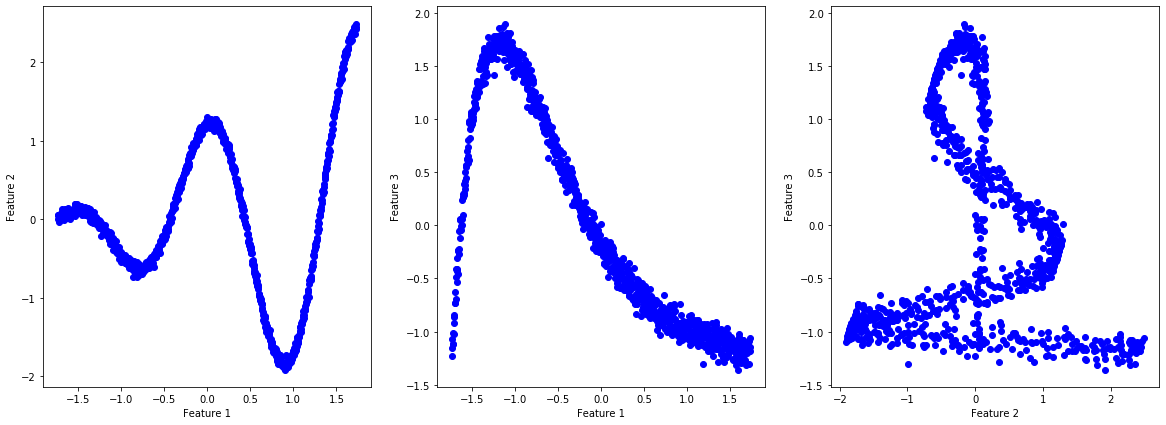

In [7]:
plots_dataset(X_tc)

In [9]:
batch_size = 25
X_dim = X_tc.shape[1]
torch_dataset = Data.TensorDataset(X_tc)
loader = Data.DataLoader(
        dataset = torch_dataset,
        batch_size = batch_size,
        shuffle=True)

In [10]:
Z_dim = 20
h_dim = 50
lr = 1e-3

# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self):
        super(GNet,self).__init__()
        self.hidden1 = torch.nn.Linear(Z_dim, h_dim)
        self.hidden2 = torch.nn.Linear(h_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z):
        h1 = F.relu(self.hidden1(z))
        h2 = F.relu(self.hidden2(h1))
        X = self.out(h2)
        return X

# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self):
        super(DNet,self).__init__()
        self.hidden = torch.nn.Linear(X_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X):
        h = F.relu(self.hidden(X))
        y = torch.sigmoid(self.out(h))
        return y

# Instanciamos as redes
G = GNet()
D = DNet()

# Definimos os otimizadores
G_optim = optim.Adam(G.parameters(), lr=lr)
D_optim = optim.Adam(D.parameters(), lr=lr)

ones  = Variable(torch.ones(batch_size, 1))
zeros = Variable(torch.zeros(batch_size, 1))

D_loss_real_func = nn.BCELoss()  
D_loss_fake_func = nn.BCELoss()
G_loss_func = nn.BCELoss()

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.001)  

def discriminator_test(n_sample,G,D):
    z = Variable(torch.randn(n_sample, Z_dim))
    G_sample = G(z)
    prob_real = D(X_tc)
    prob_fake = D(G_sample)
    print('Average real {:.6f}| Std real {:.6f}'.format(prob_real.mean(),prob_real.std()))
    print('Average fake {:.6f}| Std fake {:.6f}'.format(prob_fake.mean(),prob_fake.std()))
    
#Inicializar pesos das redes
G.apply(init_weights)
D.apply(init_weights)

DNet(
  (hidden): Linear(in_features=3, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=1, bias=True)
)

In [11]:
%%time
epochs = 500

G_his, D_his, D_real_his, D_fake_his = [[],[],[],[]]
losses_his = [G_his,D_his,D_real_his,D_fake_his] 

for epoch in range(epochs):
    for step, batch_x in enumerate(loader):
        # Amostragem de dados
        z = Variable(torch.randn(batch_size, Z_dim))
        X = Variable(batch_x[0])
        
        # Dicriminador
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        D_loss_real = D_loss_real_func(D_real, ones)
        D_loss_fake = D_loss_fake_func(D_fake, zeros)
        D_loss = D_loss_real + D_loss_fake
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()

        # Generador
        z = Variable(torch.randn(batch_size, Z_dim))
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = G_loss_func(D_fake, ones)
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()

    # Recolher dados das funções de perda
    G_his.append(G_loss.mean().data)
    D_his.append(D_loss.mean().data)
    D_fake_his.append(D_loss_fake.mean().data)
    D_real_his.append(D_loss_real.mean().data)

    # Mostrar dados ao longo das epochs
    if epoch % int(epochs/4) == 0:
        print('Epoch-{}| Average D_loss: {:.5f}| Average G_loss: {:.5f}'.format(
            epoch, D_loss.data, G_loss.data))
        discriminator_test(500,G,D)
        

Epoch-0| Average D_loss: 1.32059| Average G_loss: 0.72651
Average real 0.544620| Std real 0.067652
Average fake 0.487790| Std fake 0.017730
Epoch-125| Average D_loss: 1.18322| Average G_loss: 1.04503
Average real 0.562465| Std real 0.221298
Average fake 0.395095| Std fake 0.077286
Epoch-250| Average D_loss: 1.38623| Average G_loss: 0.73399
Average real 0.499924| Std real 0.040147
Average fake 0.490916| Std fake 0.032305
Epoch-375| Average D_loss: 1.35676| Average G_loss: 0.68629
Average real 0.508346| Std real 0.021791
Average fake 0.499339| Std fake 0.024136
CPU times: user 6min 47s, sys: 2.93 s, total: 6min 50s
Wall time: 34.5 s


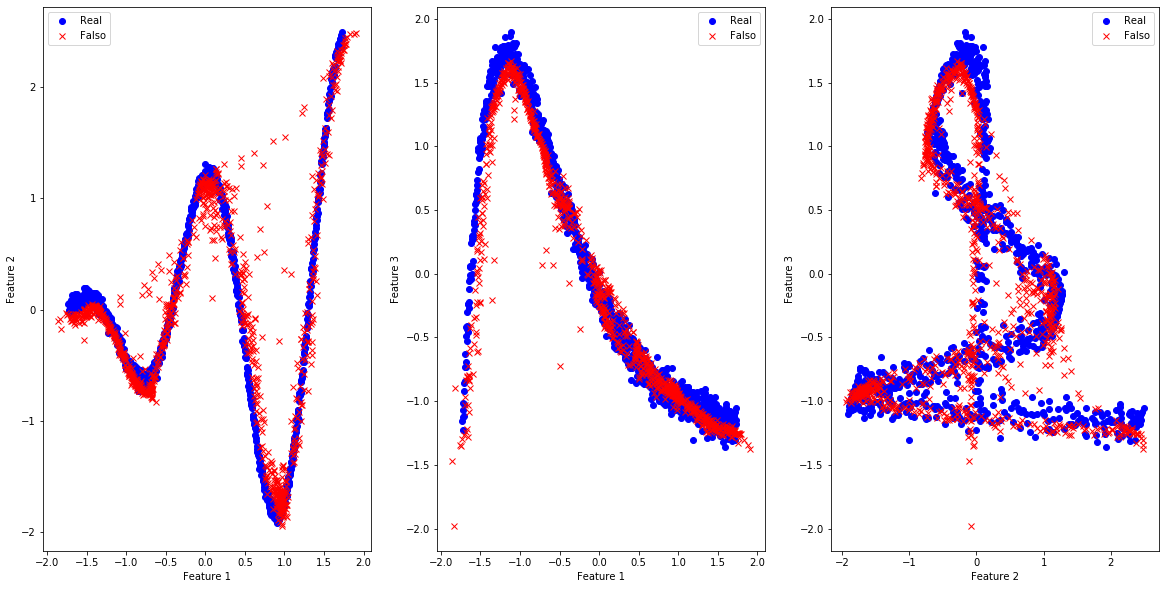

In [14]:
G_sample_plot = G(Variable(torch.randn(1000, Z_dim)))
plots_dims(X_tc,G_sample_plot)

In [16]:
discriminator_test(1000,G,D)

Average real 0.506466| Std real 0.014672
Average fake 0.503768| Std fake 0.019862


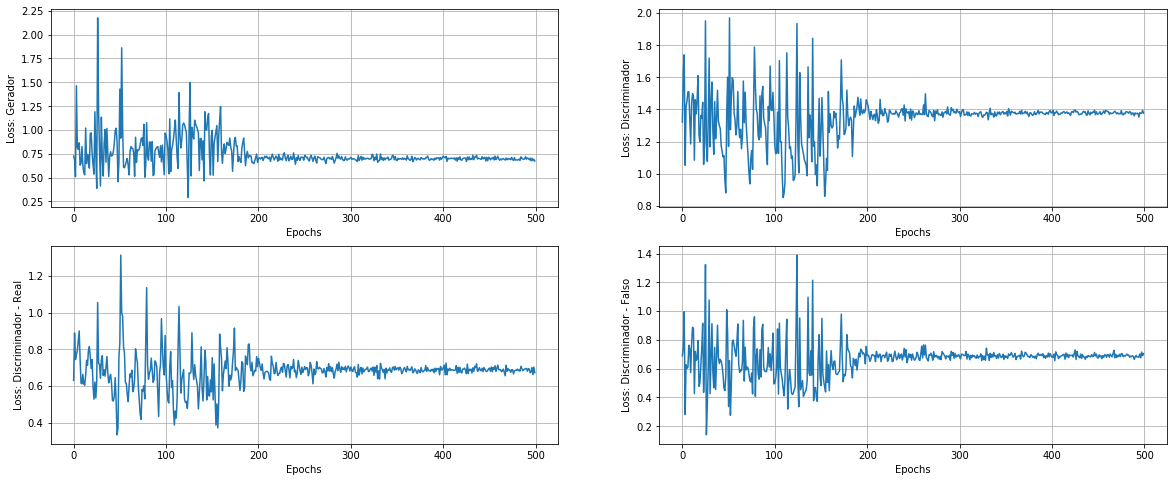

In [23]:
plot_losses(losses_his)

* Avaliando o resultado

In [25]:
z = Variable(torch.randn(1000, Z_dim))
X_fake = G(z)

In [31]:
# DataFrame real
df_real = pd.DataFrame(data=X_data,columns=['x1','x2','x3'])
df_real['reality_label'] = 1
# DataFrame falso
df_fake = pd.DataFrame(data=X_fake.data.numpy(),columns=['x1','x2','x3'])
df_fake['reality_label'] = 0
# Concatemos e embaralhamos os dois
df_mixed = pd.concat([df_real,df_fake],axis=0)
df_mixed = df_mixed.sample(frac=1.0)
# Separamos o label para ser o target
X_mixed = df_mixed.drop('reality_label',axis=1).copy()
y_mixed = df_mixed['reality_label'].copy()
# Transformamos em tensores
X_mix_tc = torch.Tensor(X_mixed.values).type(torch.FloatTensor)
y_mix_tc = torch.Tensor(y_mixed.values).type(torch.FloatTensor)

In [35]:
# Previsão
y_predict = D(X_mix_tc)

In [36]:
print("Confusion Matrix:")
print(confusion_matrix(y_mix_tc.data.numpy().reshape(2000,),np.round(y_predict.data.numpy().reshape(2000,),0)))

Confusion Matrix:
[[404 596]
 [397 603]]


In [37]:
print("Classification Report:")
print(classification_report(y_mix_tc.data.numpy().reshape(2000,),np.round(y_predict.data.numpy().reshape(2000,),0),digits=5))

Classification Report:
              precision    recall  f1-score   support

         0.0    0.50437   0.40400   0.44864      1000
         1.0    0.50292   0.60300   0.54843      1000

    accuracy                        0.50350      2000
   macro avg    0.50364   0.50350   0.49854      2000
weighted avg    0.50364   0.50350   0.49854      2000

